In [1]:
# export
import fastbook
fastbook.setup_book()

In [2]:
# export
from fastai.vision.all import *
from fastbook import *

In [3]:
# export
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

(#2) [Path('/home/john/.fastai/data/mnist_png/testing'),Path('/home/john/.fastai/data/mnist_png/training')]

In [5]:
(path/'training').ls()

(#10) [Path('/home/john/.fastai/data/mnist_png/training/7'),Path('/home/john/.fastai/data/mnist_png/training/6'),Path('/home/john/.fastai/data/mnist_png/training/2'),Path('/home/john/.fastai/data/mnist_png/training/4'),Path('/home/john/.fastai/data/mnist_png/training/0'),Path('/home/john/.fastai/data/mnist_png/training/5'),Path('/home/john/.fastai/data/mnist_png/training/9'),Path('/home/john/.fastai/data/mnist_png/training/1'),Path('/home/john/.fastai/data/mnist_png/training/3'),Path('/home/john/.fastai/data/mnist_png/training/8')]

In [6]:
im0 = Image.open(path/'training'/'0'/'4356.png')
im0

In [97]:
im0_t = tensor(im0)
df = pd.DataFrame(im0_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Grays')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,157,254,255,190,82,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,15,162,253,253,253,246,107,4,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,60,240,253,253,253,253,253,253,118,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,60,228,253,253,253,253,253,253,253,217,16,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,213,253,253,253,253,253,253,253,253,253,122,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,105,247,253,253,253,237,198,104,240,253,253,232,27,0,0,0,0,0,0,0


In [98]:
# export 

def stack(dir):
    return torch.stack([tensor(Image.open(f)) for f in dir.ls()]).float()/255

samples = [tensor(Image.open(files.ls()[0])) for files in (path/'training').ls().sorted()]
stacks = [stack(dir) for dir in (path/'training').ls().sorted()]
means = [s.mean(0) for s in stacks]

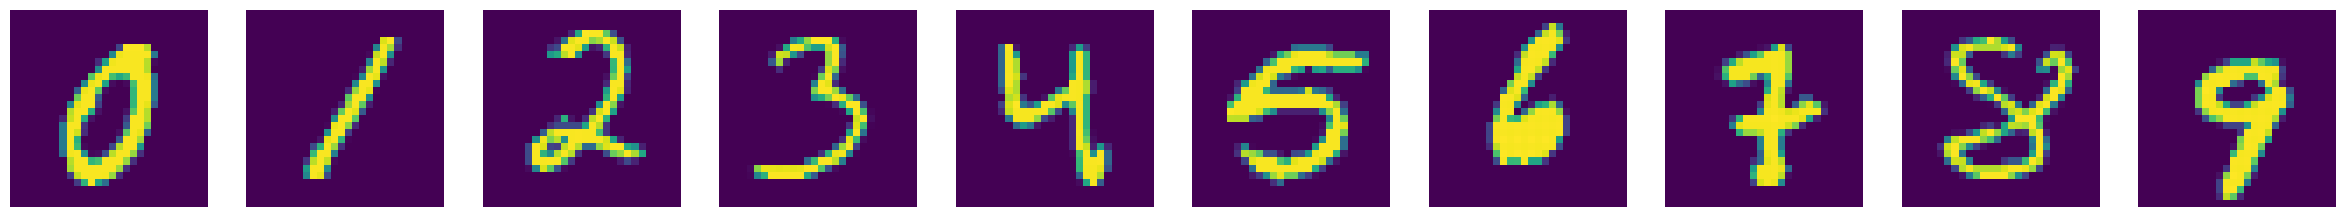

In [99]:
show_images(samples)

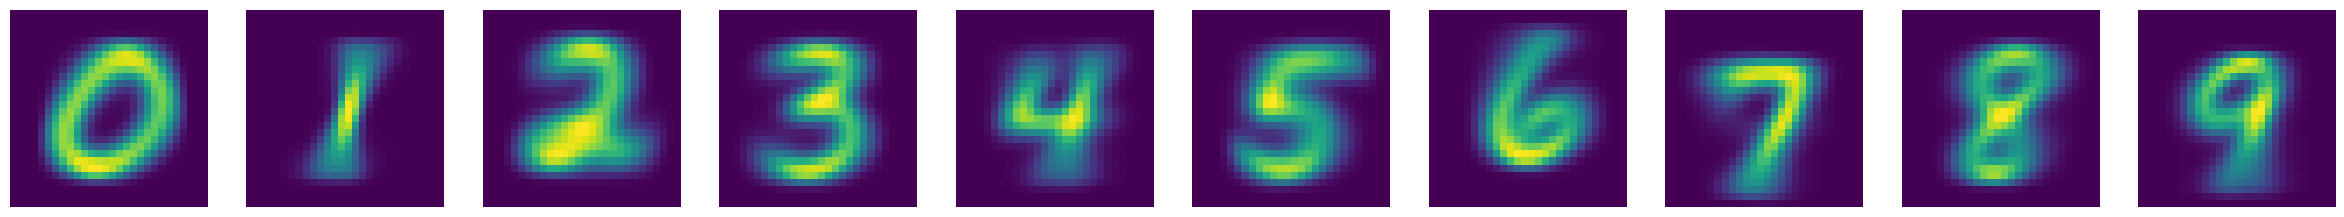

In [100]:
show_images(means, nrows=1)

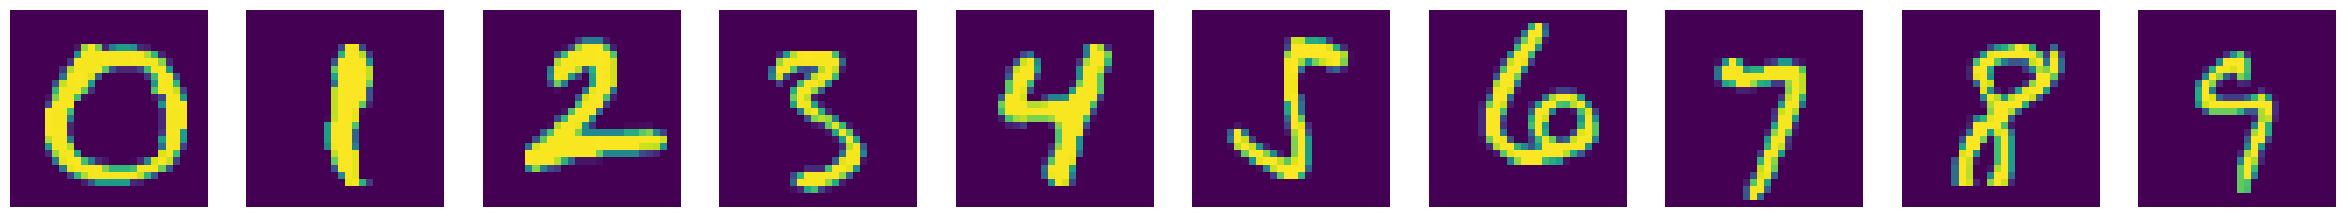

In [101]:
show_images([tensor(Image.open(files.ls()[5000])) for files in (path/'training').ls().sorted()])

In [102]:
#df = pd.DataFrame(means[0])
#df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [103]:
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))

In [104]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

def scores(sample):
    return [mnist_distance(sample, mean) for mean in means] 

import numpy as np
def classify(scores):
    return labels[np.argmin(scores)]


In [105]:
samples = [tensor(Image.open(files.ls()[8])) for files in (path/'training').ls().sorted()]
print( [classify(scores(sample)) for sample in samples] )

['0', '1', '2', '3', '9', '3', '6', '9', '8', '9']


In [106]:
# export
# Transform from list of matrices to list of arrays
train_x = torch.cat(stacks).view(-1, 28*28)
def filecount(dir):
    return len(dir.ls())
train_y = torch.cat([tensor([i]*filecount(path/'training'/f'{i}')) for i in range(10)]).unsqueeze(1)

In [107]:
# export
valid_stacks = [stack(dir) for dir in (path/'testing').ls().sorted()]
valid_x = torch.cat(valid_stacks).view(-1, 28*28)
valid_y = torch.cat([tensor([i]*filecount(path/'testing'/f'{i}')) for i in range(10)]).unsqueeze(1)

In [108]:
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)

torch.Size([60000, 784]) torch.Size([60000, 1]) torch.Size([10000, 784]) torch.Size([10000, 1])


In [109]:
# export
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

In [110]:
# export
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [111]:
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [112]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [113]:
# export
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Initialize alternating Linear and ReLU layers
        layers = []
        in_features = 784  # Input size based on 28x28 pixels
        for _ in range(5):  # n pairs of Linear and ReLU
            layers.append(nn.Linear(in_features, 128))  # Linear layer
            layers.append(nn.ReLU())  # ReLU layer
            in_features = 128  # Output size becomes input size for the next layer
            
        # Output layer
        layers.append(nn.Linear(128, 10))  # 10 classes for output
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



In [114]:
# export
def mnist_loss(predictions, targets):
    # Softmax for multi-class classification
    predictions = torch.nn.functional.softmax(predictions, dim=1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = torch.nn.functional.one_hot(targets.squeeze(), num_classes=10)
    
    # Calculate the negative log likelihood
    neg_log_likelihood = -torch.log(predictions + 1e-9)  # Adding epsilon to prevent log(0)
    
    # Multiply with one-hot targets and sum
    loss = (targets_one_hot * neg_log_likelihood).sum(dim=1)
    
    return loss.mean()

In [115]:
# export
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [116]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(0.), tensor([0.]))

In [117]:
# export
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from torch.utils.data import TensorDataset, DataLoader

def accuracy(preds, targets):
    preds = preds.argmax(dim=1)  # Get the index of the max value along dimension 1
    return (preds == targets).float().mean()  # Compare with target and average

# Your model and loss function
model = MyModel()

# Create DataLoader
train_dset = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_dset, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=64, shuffle=False)  # Assuming 'valid_dset' is your validation set
dls = DataLoaders(train_dl, valid_dl)

# Create Learner
learner = Learner(dls, model, loss_func=mnist_loss, metrics=accuracy)  # Assuming 'accuracy' is defined or imported

# Train
learner.fit(10, lr=0.01)  # Train for 10 epochs with a learning rate of 0.01


epoch,train_loss,valid_loss,accuracy,time
0,0.233750,0.258902,0.924422,00:04
1,0.208486,0.183343,0.939961,00:04
2,0.183132,0.206230,0.937964,00:04
3,0.176770,0.152492,0.942875,00:04
4,0.157218,0.196488,0.940588,00:04
5,0.164052,0.193210,0.946064,00:04
6,0.165757,0.178063,0.948337,00:04
7,0.144681,0.178215,0.947586,00:04
8,0.161810,0.222237,0.937858,00:04
9,0.133686,0.207846,0.943547,00:04


<Axes: >

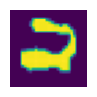

In [118]:
show_image(samples[2])

In [119]:
import nbformat

def export_cells(notebook_path, export_path, directive="# export"):
    with open(notebook_path, 'r') as f:
        notebook = nbformat.read(f, as_version=4)

    script_lines = []
    script_lines.append("# Generated by the corresponding notebook.")
    for cell in notebook.cells:
        if cell.cell_type == "code":
            if cell.source.startswith(directive):
                # Remove the first line (the directive itself)
                cleaned_source = "\n".join(cell.source.split("\n")[1:])
                script_lines.append(cleaned_source)

    with open(export_path, 'w') as f:
        f.write("\n\n".join(script_lines))

# Usage
export_cells("main.ipynb", "main.py")
